# Titanic Casualty Prediction

### Imports

In [46]:
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preparation and Cleaning

In [32]:
# Load data
data = pd.read_csv("data\\train.csv")
test = pd.read_csv("data\\test.csv")

test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [33]:
def clean(data):

    # Drop the cabin column since it has lots of missing data
    data = data.drop(['Cabin'], axis=1)

    # Fill in missing data from other columns with median values
    cols = ['SibSp', 'Parch', 'Fare', 'Age']
    for col in cols:
        data[col].fillna(data[col].median(), inplace=True)

    # Fill in missing values using mode imputation
    data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode().to_string())
    data['Fare'] = data['Fare'].fillna(data['Fare'].mode().to_string())

    data.loc[(data['Embarked'] != 'S')&(data['Embarked'] != 'C')&
             (data['Embarked'] != 'Q'), 'Embarked'] = data['Embarked'].mode()[0]
    data['Embarked'] = data['Embarked'].map({'S':1, 'C':2, 'Q':3}).astype(int)

    data['Sex'] = data['Sex'].map({'female':0, 'male':1})

    data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=False)

    data['Title'] = data['Title'].replace(['Rev', 'Dr', 'Col', 'Mlle', 'Major', 'Ms', 'Lady', 'Sir', 
                                           'Mme', 'Don', 'Capt', 'Countess', 'Jonkheer', 'Dona'], 'Others')
    data['Title'] = data['Title'].map({'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Others':5}) 

    data.loc[(data['Age'] > 0)&(data['Age'] <= 1), 'AgePeriod'] = 1
    data.loc[(data['Age'] > 1)&(data['Age'] <= 13), 'AgePeriod'] = 2
    data.loc[(data['Age'] > 13)&(data['Age'] <= 25), 'AgePeriod'] = 3
    data.loc[(data['Age'] > 25)&(data['Age'] <= 61), 'AgePeriod'] = 4
    data.loc[(data['Age'] > 61)&(data['Age'] <= 73), 'AgePeriod'] = 5
    data.loc[(data['Age'] > 73)&(data['Age'] <= 85), 'AgePeriod'] = 6
    data.loc[(data['Age'] > 85), 'AgePeriod'] = 7
    data['AgePeriod'] = data['AgePeriod'].astype(int)

    data['Accompanied'] = data['Ticket'].duplicated(keep=False).astype(int)

    data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=False)
    data['Title'] = data['Title'].replace(['Rev', 'Dr', 'Col', 'Mlle', 'Major', 'Ms', 'Lady', 
                                           'Sir', 'Mme', 'Don', 'Capt', 'Countess', 'Jonkheer', 'Dona'], 'Others')
    data['Title'] = data['Title'].map({'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Others':5}) 

    data['FareBin'] = pd.qcut(data['Fare'], q = 4, labels = [1, 2, 3, 4]).astype(int)

    return data

    
data = clean(data)
#test = clean(test)

# Check for null values 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    int32  
 11  Title        891 non-null    int64  
 12  AgePeriod    891 non-null    int32  
 13  Accompanied  891 non-null    int32  
 14  FareBin      891 non-null    int32  
dtypes: float64(2), int32(4), int64(7), object(2)
memory usage: 90.6+ KB


In [34]:
dropped_column = ['Age', 'Fare', 'Name', 'Parch', 'SibSp', 'Ticket']
for i in dropped_column:
    data = data.drop([i], axis=1)

data.head()

,PassengerId,Survived,Pclass,Sex,Embarked,Title,AgePeriod,Accompanied,FareBin
0,1,0,3,1,1,1,3,0,1
1,2,1,1,0,2,3,4,0,4
2,3,1,3,0,1,2,4,0,2
3,4,1,1,0,1,3,4,1,4
4,5,0,3,1,1,1,4,0,2


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  891 non-null    int64
 1   Survived     891 non-null    int64
 2   Pclass       891 non-null    int64
 3   Sex          891 non-null    int64
 4   Embarked     891 non-null    int32
 5   Title        891 non-null    int64
 6   AgePeriod    891 non-null    int32
 7   Accompanied  891 non-null    int32
 8   FareBin      891 non-null    int32
dtypes: int32(4), int64(5)
memory usage: 48.9 KB


In [38]:
data.describe()

,PassengerId,Survived,Pclass,Sex,Embarked,Title,AgePeriod,Accompanied,FareBin
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,1.361392,1.740741,3.590348,0.386083,2.497194
std,257.353842,0.486592,0.836071,0.477990,0.635673,1.052077,0.718517,0.487123,1.118156
min,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,0.000000,1.000000,1.000000,3.000000,0.000000,1.500000
50%,446.000000,0.000000,3.000000,1.000000,1.000000,1.000000,4.000000,0.000000,2.000000
75%,668.500000,1.000000,3.000000,1.000000,2.000000,2.000000,4.000000,1.000000,3.000000
max,891.000000,1.000000,3.000000,1.000000,3.000000,5.000000,6.000000,1.000000,4.000000


C:\Users\sydne\AppData\Local\Temp\ipykernel_8208\65244676.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


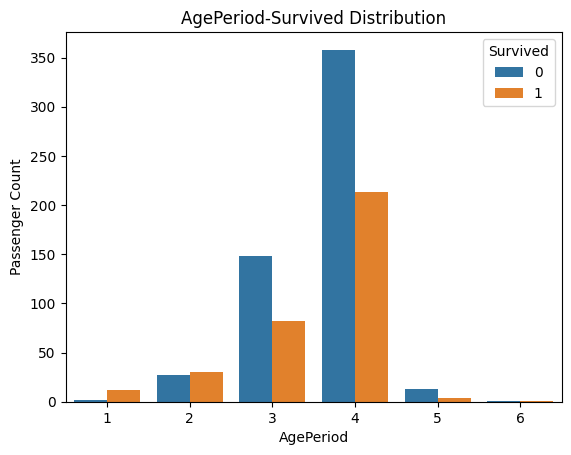

In [50]:
fig = plt.figure()
ax = sns.countplot(data=data, x='AgePeriod',hue='Survived')
ax.set_title('AgePeriod-Survived Distribution')
ax.set_xlabel('AgePeriod')
ax.set_ylabel('Passenger Count')
fig.add_subplot(ax)
fig.show()

C:\Users\sydne\AppData\Local\Temp\ipykernel_8208\2473995395.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


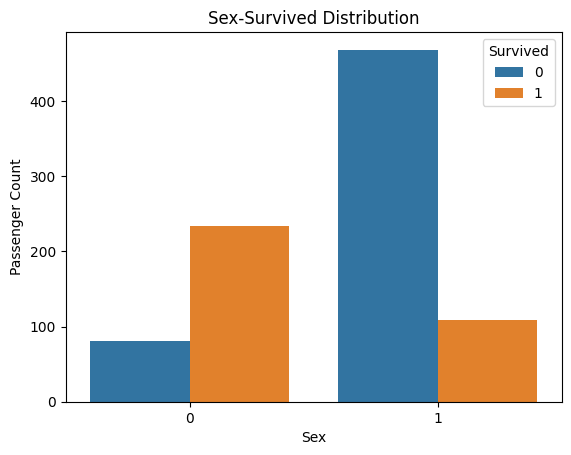

In [52]:
fig = plt.figure()
ax = sns.countplot(data=data, x='Sex', hue='Survived')
ax.set_title('Sex-Survived Distribution')
ax.set_xlabel('Sex')
ax.set_ylabel('Passenger Count')
fig.add_subplot(ax)
fig.show()

C:\Users\sydne\AppData\Local\Temp\ipykernel_8208\86428113.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


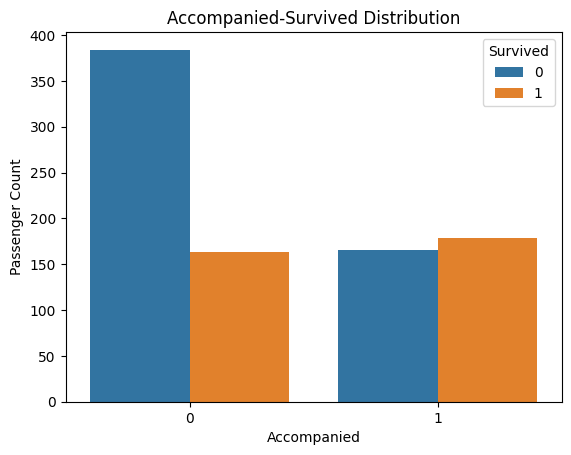

In [53]:
fig = plt.figure()
ax = sns.countplot(data=data, x='Accompanied',hue='Survived')
ax.set_title('Accompanied-Survived Distribution')
ax.set_xlabel('Accompanied')
ax.set_ylabel('Passenger Count')
fig.add_subplot(ax)
fig.show()

C:\Users\sydne\AppData\Local\Temp\ipykernel_8208\3064779155.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


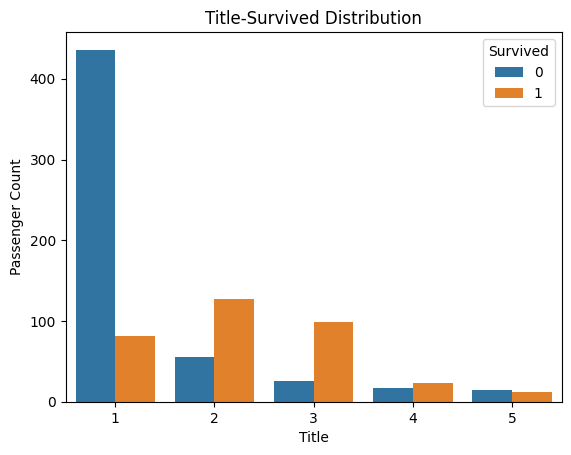

In [54]:
fig = plt.figure()
ax = sns.countplot(data=data, x='Title', hue='Survived')
ax.set_title('Title-Survived Distribution')
ax.set_xlabel('Title')
ax.set_ylabel('Passenger Count')
fig.add_subplot(ax)
fig.show()

C:\Users\sydne\AppData\Local\Temp\ipykernel_8208\4198606405.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


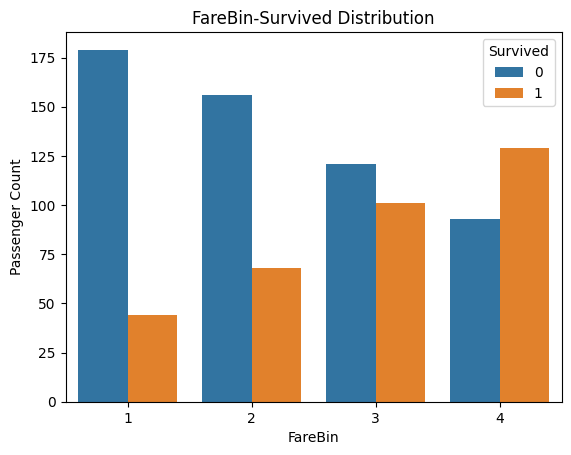

In [56]:
fig = plt.figure()
ax = sns.countplot(data=data, x='FareBin',hue='Survived')
ax.set_title('FareBin-Survived Distribution')
ax.set_xlabel('FareBin')
ax.set_ylabel('Passenger Count')
fig.add_subplot(ax)
fig.show()

### Model Experimentation

C:\Users\sydne\AppData\Local\Temp\ipykernel_8208\2679666184.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


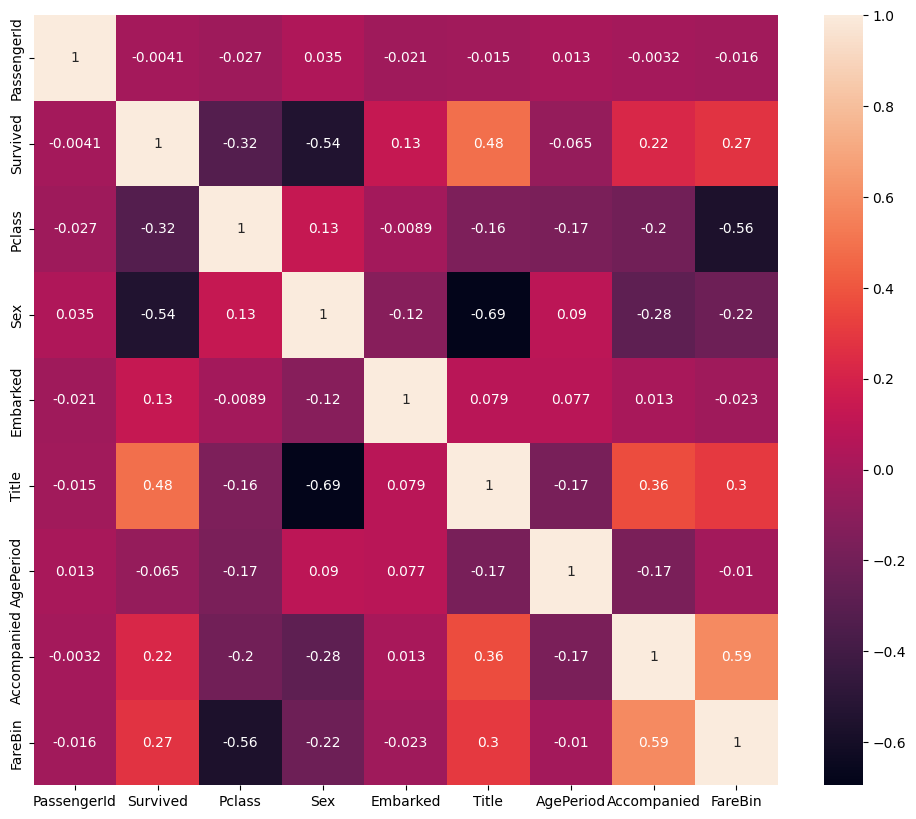

In [58]:

X = data.drop(['Survived', 'PassengerId'], axis=1)
y = data['Survived']

correlation = data.corr(method='kendall')
fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(correlation, annot=True)
fig.add_subplot(ax)
fig.show()



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0)